In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
import keras
from tensorflow.keras import activations
import copy
from tensorflow.python.client import device_lib
#tf.config.list_physical_devices("GPU")
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15947261074839541360]

In [2]:
sampledir = os.path.join(os.getcwd(), "dataset/samples")
sampleNotes = []

for f in os.listdir(sampledir):
    sampleNotes.append(cv2.resize(cv2.imread(os.path.join(sampledir,f"{f}")), (20,100)))

In [3]:
 
train = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/train/notev7.json")))
val = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/val/notev7.json")))
test = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/test/notev7.json")))

trainStaff = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/train/StaffAndSep.json")))
valStaff = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/val/StaffAndSep.json")))
testStaff = json.load(open(os.path.join(os.getcwd(), "dataset/Notev1/test/StaffAndSep.json")))



def extractData(datasetStaff, datasetNotes, dirn = None):
    mask = []
    TotalSortedList = []
    for data in datasetStaff:
        annotation = [a for a in datasetStaff[data]['regions']]
        sortedList = [i for i in range(len(annotation))]
        for k_index, a in enumerate(sortedList): 
            index  = k_index
            if index != len(sortedList) -1:
                while index < len(sortedList)-1:
                    if annotation[a]['shape_attributes']['y'] > annotation[sortedList[index+1]]["shape_attributes"]["y"]:
                        i = sortedList[index+1]
                        sortedList[index+1] = sortedList[index]
                        sortedList[index] = i
                        break
                    index += 1

            if index > 0:
                while index > 0:
                    if annotation[sortedList[index]]['shape_attributes']['y'] < annotation[sortedList[index-1]]["shape_attributes"]["y"]:
                        i = sortedList[index-1]
                        sortedList[index-1] = sortedList[index]
                        sortedList[index] = i
                    index -= 1

        TotalSortedList.append(sortedList)


    TrainDataset = []
    ValDataset = []
    c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']


    for image in datasetNotes:
        if len(datasetNotes[image]['regions']) > 0:
            _id = ''
            index = 0
            for i, a in enumerate(datasetStaff):
                if datasetNotes[image]['filename'] == datasetStaff[a]['filename']:
                    _id  = a
                    index = i
                    break

            img = cv2.imread(os.path.join(os.getcwd(), f"dataset/Notev1/{dirn}/{datasetNotes[image]['filename']}"))
            start, end = 0, img.shape[0]

            b = 0
            while b < len(TotalSortedList[index]):
                Height = datasetStaff[_id]['regions'][TotalSortedList[index][b]]['shape_attributes']['height']
                if b > 0: 
                    start = datasetStaff[_id]['regions'][TotalSortedList[index][b-1]]['shape_attributes']['y']

                if b + 1 < len(TotalSortedList[index]):
                    end = datasetStaff[_id]['regions'][TotalSortedList[index][b+1]]['shape_attributes']['y']


                
                for note in datasetNotes[image]['regions']:
                    load = False
                    if note["region_attributes"]['class_ids'] in c:
                        load = True


                    if load == True and note['shape_attributes']['y'] > start and note['shape_attributes']['y'] + note['shape_attributes']['height'] < end:
                        
                        
                        
                        x = note['shape_attributes']['x']
                        y = note['shape_attributes']['y']
                        w = note['shape_attributes']['width']
                        h = note['shape_attributes']['height']
                        sh = datasetStaff[_id]['regions'][TotalSortedList[index][b]]['shape_attributes']['height']
                        sy = datasetStaff[_id]['regions'][TotalSortedList[index][b]]['shape_attributes']['y']
                        
                        def distribute(data):
                            distri = []

                            av = np.average(data)
                            for i, r in enumerate(data):
                                distri.append(0)
                                for c in r:
                                    if  0.299*c[0] + 0.587*c[1] + 0.114*c[2] < av:

                                        distri[i] += 1

                            distri = np.array(distri)/data.shape[1]
                            
                            for i,v in enumerate(distri):
                                if v > 0.9:
                                    distri[i] = 0
                                else:
                                    distri[i] = 1
                                    
                            return distri
                        
                        
                       
                        endm = int(sy+2*Height)
                        startm = int(sy - Height)
                        if endm > (int(end)):
                            endm = int(end)
                        
                        if startm < start:
                            startm = start
                            
                        topmost = sy-startm
                        bottommost = y+h - startm
                        
                        if y-startm < topmost:
                            topmost = y - startm
                        
                        if bottommost < sy + sh -startm:
                            bottommost = sy + sh - startm
                        
                        
                        #mask = np.zeros((3*sh,w,6))
                            
                        mask = []
                        cmask =  copy.deepcopy(img[startm:endm,x:x+w,:])
                        staffFilter = distribute(img[sy:sy+sh,x:x+w,:])
            
                        
                        bmask = np.zeros((cmask.shape[0],cmask.shape[1],3)) + 255
                        bmask[sy-startm: sy+sh-startm,:,:] = 0
                        #mask.append(img[startm:endm,x:x+w,:])
                        
                        background = np.average(img[startm:endm,x:x+w,:]) + 255
                        background /= 2
                        
                        cmask[0:sy-startm,:,:] = background
                        cmask[sy+sh-startm: cmask.shape[0], :,:] = background
                        
                        bmask = copy.deepcopy(cmask)
                        
                        gooddata = True
                        
                        notem = np.zeros((h, w,3))
                        hrw = h/w
                        for nr in range(h):
                            for nc in range(w):
                                if (nr - h/2)**2 + (hrw)**2*(nc - w/2)**2 < h**2/4:
                                    notem[nr, nc,:] = 1
                                    
                        try:
                        
                            for mr, rv in enumerate(notem):
                                for mc,cv in enumerate(rv):
                                    if cv[0]== 0:
                                        cmask[y-startm+mr, mc,:] = 255
                                    else:
                                        cmask[y-startm+mr, mc,:] = copy.deepcopy(img[y+mr,x+mc,:])
                        except:
                            gooddata = False
                            pass
                        #print(h)
                        
                        #cmask[y - startm: y+h - startm,:,:] = copy.deepcopy(notem)
                        #print(h)
                                    
                                    
                        
                                
                                    
                            
                        #cmask = cv2.resize(cmask, (20,100))
                        #bmask = cv2.resize(bmask, (20,100))
                        
                        def finetuneImage(data, fil):
                            data = np.array(data)
                            fil = np.array(fil)
                            for i, v in enumerate(data):
                                for j,a in enumerate(v):
                                    data[i,j,0] *= fil[i]
                                    data[i,j,1] *= fil[i]
                                    data[i,j,2] *= fil[i]
                            
                            return data
                        
                        cmask[sy-startm: sy+sh-startm,:,:] = finetuneImage(cmask[sy-startm: sy+sh-startm,:,:], staffFilter)
                        
                        def distribute(data):
                            distri = []
                            av = np.average(data)
                            for i, r in enumerate(data):
                                distri.append(0)
                                for c in r:
                                    if  0.299*c[0] + 0.587*c[1] + 0.114*c[2] < av:

                                        distri[i] += 1
                                        
                            distri = np.array(distri)/data.shape[1]
                            
                            #pos = [1,0]

                            #for i,v in enumerate(distri):
                            #    if v > 0.8:
                            #        pos[0] = i
                            #        break
                            
                            #for i in range(len(distri)):
                            #    if distri[len(distri) - i-1] == 1:
                            #        pos[1]= len(distri) - i-1
                            #        break

                            return distri
                        
                        spos = distribute(cmask)
                        subsh = sh/4
                        rjk = spos
                        
                        
                        mask.append(cmask)
                        mask.append(copy.deepcopy(img[startm:endm,x:x+w,:]))
                      
                        
            
                        
                        
                        if gooddata == True:
                            TrainDataset.append({'mask': [cv2.resize(cmask, (20,100)),rjk], "class_ids": note["region_attributes"]['class_ids']})
                            
                            if dirn == 'train':
                                down = 5
                                while bottommost + down < mask[0].shape[0]:
                                    temcm = np.zeros(mask[0].shape) + 255
                                    temcm[topmost+down: bottommost+down,:,:] = copy.deepcopy(mask[0][topmost:bottommost,:,:])
                                    tembm = np.zeros(mask[1].shape) + 255
                                    tembm[topmost+down: bottommost+down,:,:] = copy.deepcopy(mask[1][topmost:bottommost,:,:])
                                    down += 5
                                    TrainDataset.append({'mask': [cv2.resize(temcm, (20,100)), rjk], "class_ids": note["region_attributes"]['class_ids']})
                                    expandDim = np.zeros((6,temcm.shape[1],3)) + 255
                                    #for k in range(10):
                                    #    temcm = np.concatenate((temcm,expandDim))
                                    #    TrainDataset.append({'mask': [cv2.resize(temcm, (20,100)), rjk], "class_ids": note["region_attributes"]['class_ids']})
                                    
                                down = 5
                                while topmost-down > 0:
                                    temcm = np.zeros(mask[0].shape) + 255
                                    temcm[topmost-down: bottommost-down,:,:] = copy.deepcopy(mask[0][topmost:bottommost,:,:])
                                    tembm = np.zeros(mask[1].shape) + 255
                                    tembm[topmost-down: bottommost-down,:,:] = copy.deepcopy(mask[1][topmost:bottommost,:,:])
                                    down += 5
                                    TrainDataset.append({'mask': [cv2.resize(temcm, (20,100)),rjk], "class_ids": note["region_attributes"]['class_ids']})
                                    expandDim = np.zeros((6,temcm.shape[1],3)) + 255
                                    #for k in range(10):
                                    #    temcm = np.concatenate((expandDim, temcm))
                                    #    TrainDataset.append({'mask': [cv2.resize(temcm, (20,100)), rjk], "class_ids": note["region_attributes"]['class_ids']})
                                
                            
                            



                b += 2    
    dict_c = {}
    for i, _class in enumerate(c):
        dict_c[_class] = i


    TotalMask = [[] for i in range(len(c))]
 
    

    
    for i in TrainDataset:
        TotalMask[dict_c[i['class_ids']]].append(i['mask'])
    
    return TotalMask

train_dataset = extractData(trainStaff,train, 'train')
val_dataset = extractData(valStaff, val, 'val')
test_dataset = extractData(testStaff, test, 'test')

testM_x = []

test_y = []

trainM_x = []

train_y = []

valM_x = []

val_y = []

for i,data in enumerate(train_dataset):
    for k, info in enumerate(data):
        trainM_x.append(info)
        
        train_y.append(i)
        
for i,data in enumerate(val_dataset):
    for k, info in enumerate(data):
        valM_x.append(info)
        
        val_y.append(i)
        
for i,data in enumerate(test_dataset):
    for k, info in enumerate(data):
        testM_x.append(info)
       
        test_y.append(i)
        

train_y = np.array(train_y)

trainM_x = np.array(trainM_x)


val_y = np.array(val_y)

valM_x = np.array(valM_x)


test_y = np.array(test_y)
  
testM_x = np.array(testM_x)

        
    

c:\users\lemin\miniconda3\envs\musicnote\lib\site-packages\ipykernel_launcher.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\lemin\miniconda3\envs\musicnote\lib\site-packages\ipykernel_launcher.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\lemin\miniconda3\envs\musicnote\lib\site-packages\ipykernel_launcher.py:327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

In [4]:
def split_img(data):
    finalized_data = []
    for y in range(10):
        for i in range(2):
            finalized_data.append(data[20*y: 20*(y+1), 25*i: 25*(i+1),:])
    return np.array(finalized_data)
#print(np.array(sampleNotes).shape)

def extract_infor(dataset):
    image1 = []
    image2 = []
    for i, v in enumerate(dataset):
        image1.append(np.rot90(v[0]))
        image2.append(v[0])
        
    
    return np.array(image1)/255, np.array(image2)/255

trainM1_x, trainM2_x = extract_infor(trainM_x)
testM1_x, testM2_x = extract_infor(testM_x)
valM1_x, valM2_x = extract_infor(valM_x)

(3583, 20, 100, 3)
(3583, 100, 20, 3)


IndexError: index 4010 is out of bounds for axis 0 with size 3583

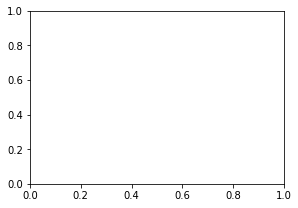

In [5]:
fig = plt.figure(figsize = (10,7))

j =  4010

#fig.add_subplot(2, 2, 1)
#plt.imshow(trainM2_x[j])
print(trainM1_x.shape)
print(trainM2_x.shape)
fig.add_subplot(2, 2, 2)
plt.imshow(trainM2_x[j])

In [6]:
def distribute(datas):
    allDis = []
    for data in datas:
        distri = [] 
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        av = np.average(data)
        for i in range(data.shape[1]):
            distri.append([0,0,0])
            for c in data[:,i,:]:
                if  0.299*c[0] + 0.587*c[1] + 0.114*c[2] < av:

                    distri[i][0]+= 1
                    distri[i][1]+= 1
                    distri[i][2]+= 1
                   
        
        distri = np.array(distri)/20
        
        for i in range(len(distri)):
            if distri[i][0] < 0.1:
                distri[i][0] = 0
                distri[i][1] = 0
                distri[i][2] = 0
            else:
                distri[i][0] = 1
                distri[i][1] = 1
                distri[i][2] = 1
        allDis.append(distri)
    
    
    return np.array(allDis)

trainM2_x = distribute(trainM1_x)
testM2_x = distribute(testM1_x)
valM2_x = distribute(valM1_x)
        

(3583, 100, 3)


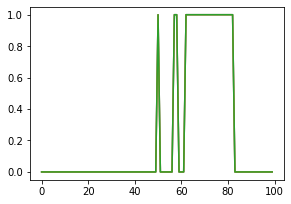

In [7]:
fig = plt.figure(figsize = (10,7))

j = 2000

#fig.add_subplot(2, 2, 1)
#plt.imshow(trainM2_x[j])
print(trainM2_x.shape)
fig.add_subplot(2, 2, 1)
x = [i for i in range(len(trainM2_x[j]))]
plt.plot(x, trainM2_x[j])

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


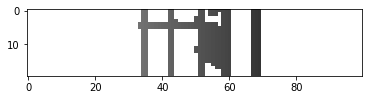

In [23]:
class noteFocustest(keras.layers.Layer):
    def __init__(self):
        super(noteFocustest, self).__init__()
    
    def build(self, input_shape):
        self.space = np.zeros((100,3))
        for i in range(self.space.shape[0]):
            self.space[i][0] = i + 50
            self.space[i][1] = i + 50
            self.space[i][2] = i +50
        self.space = self.space/150
        self.space = tf.convert_to_tensor(self.space, dtype = tf.float32)
        
        
    def get_w(self):
        return self.space
        
    def call(self, inputs):
        #r = tf.math.multiply(self.space, tf.cast(inputs, dtype = tf.float64))
        #mean = tf.cast(tf.math.reduce_mean(inputs),dtype = tf.float64)
        mean = tf.cast(tf.math.reduce_mean(inputs),dtype = tf.float64)
        r = tf.math.divide(inputs, mean)
        #r = tf.math.pow(r, 2)
        #r = tf.math.add(self.space, r)
        
        #r = tf.math.multiply(self.space, r)
        #r = tf.math.subtract(tf.cast(inputs, dtype = tf.float64), r)
        r = tf.cast(r, dtype = tf.int32)
        
        r = tf.cast(r, dtype = tf.float32)
        r = tf.math.subtract(1.0, r)
        r = tf.math.multiply(self.space,r)
        r = tf.math.subtract(1.0, r)
        #r = tf.math.subtract(1.0, r)

        
        
        return r

nf = noteFocustest()
nf.build(3)

b = nf.call(tf.convert_to_tensor(trainM1_x[1650]))
b = b.eval(session = tf.Session())
plt.imshow(b)
print(b)



In [184]:
class noteFocus(keras.layers.Layer):
    def __init__(self):
        super(noteFocus, self).__init__()
    
    def build(self, input_shape):
        self.space = np.zeros((100,3))
        for i in range(self.space.shape[0]):
            self.space[i][0] = i - 0
            self.space[i][1] = i - 0
            self.space[i][2] = i - 0
        self.space = self.space/100
        self.space = tf.convert_to_tensor(self.space, dtype = tf.float64)
        
        
    def get_w(self):
        return self.space
        
    def call(self, inputs):
        r = tf.math.multiply(self.space, tf.cast(inputs, dtype = tf.float64))
        r = tf.math.subtract(tf.cast(inputs, dtype = tf.float64), r)
        r = tf.cast(r, dtype = tf.float32)
        return r

class noteDistri(keras.layers.Layer):
    def __init__(self):
        super(noteDistri, self).__init__()
    
    def build(self, input_shape):
        self.x = tf.placeholder_with_default(tf.convert_to_tensor(np.zeros((20,100,3)), dtype = tf.float64), shape = [20,100,3]) 
        
    def get_input(self, data):
        distri = []
        av = np.average(data)
        for i in range(data.shape[1]):
            distri.append([0,0,0])
            for c in data[:,i,:]:
                if  0.299*c[0] + 0.587*c[1] + 0.114*c[2] > av:

                    distri[i][0]+= 1
                    distri[i][1]+= 1
                    distri[i][2]+= 1
                   
        
        distri = np.array(distri)/20
        
        
        return distri
        
    def call(self, inputs):
        mean = tf.math.reduce_mean(inputs)
        k = tf.where(inputs < mean)
        print(k)
        return k
                   

Tensor("Where:0", shape=(?, 3), dtype=int64)


<AxesSubplot:>

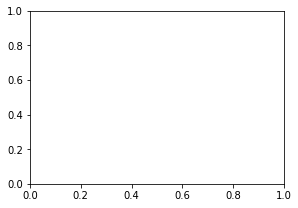

In [185]:
bv = noteDistri()
nb = noteFocus()
nb.build(3)
bv.build(3)


bv = bv.call(tf.convert_to_tensor(trainM1_x[1200]))
nb = nb.call(bv)

nb = tf.math.multiply(tf.convert_to_tensor(trainM1_x[1200], dtype = tf.float32), nb)

#nb = nb.eval(session = tf.Session())
fig = plt.figure(figsize = (10,7))

j = 1200

fig.add_subplot(2, 2, 1)
#plt.imshow(nb)


In [20]:
import keras
from tensorflow.keras import activations
from tensorflow.keras import layers
c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']

class noteFocus(keras.layers.Layer):
    def __init__(self):
        super(noteFocus, self).__init__()
    
    def build(self, input_shape):
        self.space = np.zeros((100,3))
        for i in range(self.space.shape[0]):
            self.space[i][0] = i + 50
            self.space[i][1] = i + 50
            self.space[i][2] = i +50
        self.space = self.space/150
        self.space = tf.convert_to_tensor(self.space, dtype = tf.float32)
        
        
    def get_w(self):
        return self.space
        
    def call(self, inputs):
        #r = tf.math.multiply(self.space, tf.cast(inputs, dtype = tf.float64))
        #mean = tf.cast(tf.math.reduce_mean(inputs),dtype = tf.float64)
        mean = tf.cast(tf.math.reduce_mean(inputs),dtype = tf.float32)
        r = tf.math.divide(inputs, mean)
        #r = tf.math.pow(r, 2)
        #r = tf.math.add(self.space, r)
        
        #r = tf.math.multiply(self.space, r)
        #r = tf.math.subtract(tf.cast(inputs, dtype = tf.float64), r)
        r = tf.cast(r, dtype = tf.int32)
        
        r = tf.cast(r, dtype = tf.float32)
        r = tf.math.subtract(1.0, r)
        r = tf.math.multiply(self.space,r)
        r = tf.math.subtract(1.0, r)
        #r = tf.math.subtract(1.0, r)

        
        
        return r




def conv_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    
    shotcut = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    shotcut = keras.layers.Activation(activations.relu)(shotcut)

    x = keras.layers.Add()([x, shotcut])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x

def identity_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)

    x = keras.layers.Add()([x, input_tensor])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x



#inputs = keras.layers.Input(shape = [100,20,3])

input_tensor = keras.layers.Input(shape = [20,100,3], name = "input")
distri_tensor = keras.layers.Input(shape = [100,3])


#distri_tensor = noteDistri()(input_tensor)
#o = noteFocus()(distri_tensor)
#reshape = keras.layers.Reshape((20,100,3))(input_tensor)
x = noteFocus()(input_tensor)
#x = keras.layers.Multiply()([o, input_tensor])


x = conv_block(64,3,x)
x = identity_block(64,3,x)
x = identity_block(64,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = conv_block(128,3,x)
x = identity_block(128,3,x)
x = identity_block(128,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = conv_block(256,3,x)
x = identity_block(256,3,x)
x = identity_block(256,3,x)
x = identity_block(256,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
x = conv_block(512,3,x)
x = identity_block(512,3,x)
x = identity_block(512,3,x)
x = identity_block(512,3,x)
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

x = keras.layers.Flatten()(x)
#o = keras.layers.Dense(4096)(o)
a = keras.layers.Dense(4096, activation = 'relu')(x)
#a = keras.layers.Multiply()([o,a])

a = keras.layers.Dense(2048, activation = 'relu')(a)

a = keras.layers.Dense(1024, activation = 'relu')(a)
a = keras.layers.Dense(512, activation = 'relu')(a)
a = keras.layers.Dense(256, activation = 'relu')(a)
a = keras.layers.Dense(128, activation = 'relu')(a)
a = keras.layers.Dense(96, activation = 'relu')(a)      
a = keras.layers.Dense(48, activation = 'relu')(a)  
output = keras.layers.Dense(len(c), activation = "softmax")(a)


model  = keras.Model(inputs = [input_tensor, distri_tensor], outputs = [output])

with tf.device('/CPU:0'):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])


In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#aug = ImageDataGenerator(zoom_range=0.2,vertical_flip=True)
aug = ImageDataGenerator()



In [84]:
def generator_img(x, y):
    xob = []
    for a in x:
        xob.append(aug.flow(a, y,seed=1))
        
    
    
    while True:
        xc = []
        for a in xob:
            xc.append(a.next())
        yield [b[0] for b in xc], xc[0][1]

In [233]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [234]:
model.load_weights("NoteClassificationv3.h5")

In [86]:
import multiprocessing
with tf.device('/CPU:0'):
    his = model.fit_generator(aug.flow([trainM1_x, trainM2_x], train_y), epochs = 5, steps_per_epoch =len(trainM2_x) , validation_steps = 300, validation_data=([valM1_x, valM2_x], val_y), shuffle=True, workers= multiprocessing.cpu_count())

Epoch 1/5
3583/3583 [==============================] - 1040s 290ms/step - loss: 0.0401 - acc: 0.9900 - val_loss: 2.3336 - val_acc: 0.5753
Epoch 2/5
3583/3583 [==============================] - 1047s 292ms/step - loss: 8.7970e-04 - acc: 0.9998 - val_loss: 2.7601 - val_acc: 0.5890
Epoch 3/5
3583/3583 [==============================] - 1047s 292ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 2.0404 - val_acc: 0.6027
Epoch 4/5
3583/3583 [==============================] - 1039s 290ms/step - loss: 0.0029 - acc: 0.9995 - val_loss: 2.4400 - val_acc: 0.6575
Epoch 5/5
3583/3583 [==============================] - 1044s 291ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 2.0919 - val_acc: 0.6438


In [ ]:
import multiprocessing
with tf.device('/CPU:0'):
    his = model.fit_generator(aug.flow([trainM1_x, trainM2_x], train_y), epochs = 5, steps_per_epoch =len(trainM2_x) , validation_steps = 200, validation_data=([valM1_x, valM2_x], val_y), shuffle=True, workers= multiprocessing.cpu_count())

In [ ]:
import multiprocessing
with tf.device('/CPU:0'):
    his = model.fit_generator(aug.flow([trainM1_x, trainM2_x], train_y), epochs = 5, steps_per_epoch = len(trainM2_x) , validation_steps = 100, validation_data=([valM1_x,valM2_x], val_y), shuffle=True, workers= multiprocessing.cpu_count())

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
import multiprocessing
with tf.device('/CPU:0'):
    his = model.fit_generator(generator_img(trainX, train_y), epochs = 5, steps_per_epoch = 500 , validation_steps = 100, validation_data=([*tuple(valX)], val_y), shuffle=True, workers= multiprocessing.cpu_count())

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.0001, momentum = 0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [31]:
import keras
from tensorflow.keras import activations
from tensorflow.keras import layers
c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']

def conv_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    
    shotcut = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    shotcut = keras.layers.Activation(activations.relu)(shotcut)

    x = keras.layers.Add()([x, shotcut])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x

def identity_block(size, strike, input_tensor):
    x = keras.layers.Conv2D(size,strike, padding = "same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)
    x = keras.layers.Conv2D(size,strike, padding = "same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activations.relu)(x)

    x = keras.layers.Add()([x, input_tensor])
    x = keras.layers.Activation(activations.relu)(x)
    
    return x

def sub_block(input_tensor):
    x = keras.layers.Flatten()(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    value = keras.layers.Dense(20, activation = "relu")(x)
    key = keras.layers.Dense(20, activation = "tanh")(x)
    query = keras.layers.Dense(20 ,activation = "tanh")(x)
    d = 1
    for i in key.output_shape:
        d *= i
    
    qv = keras.layers.Dot(axis = 1)([value, query])/ (d**(1/2))
    qv = keras.layers.Activation(activationns.softmax)(kv)
    
    x = keras.layers.Multiply()([qv, value])
    x = keras.layers.BatchNormalization()(x)
    return x


inputs = [keras.layers.Input(shape = [100,20,3]) for i in range(len(c))]

conv_layers = []

#origin_layer = conv_block(64,3,inputs[0])
#origin_layer = identity_block(64,3,origin_layer)
#origin_layer = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(origin_layer)
    
#origin_layer = conv_block(128,3,origin_layer)
#origin_layer = identity_block(128,3,origin_layer)
#origin_layer = identity_block(128,3,origin_layer)
#origin_layer = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(origin_layer)
origin_layer = keras.layers.Flatten()(inputs[0])
origin_layer = keras.layers.Dense(2048, activation = "relu")(origin_layer)
hidden_A = 0
for i in range(1,len(inputs)):
    #x = conv_block(64,3,inputs[i])
    #x = identity_block(64,3,x)
    #x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    #x = conv_block(128,3,x)
    #x = identity_block(128,3,x)
    #x = identity_block(128,3,x)
    #x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    x = keras.layers.Flatten()(inputs[i])
    x = keras.layers.Dense(2048, activation = "relu")(x)
    if i == 1:
        hidden_A = keras.layers.Dot(axes = 1)([origin_layer, x])
    
    else:
        hidden_A = keras.layers.Concatenate()([hidden_A, keras.layers.Dot(axes = 1)([origin_layer, x])])
    

hidden_A = keras.layers.Dense(4096, activation = "relu")(hidden_A)
hidden_A = keras.layers.Dense(2048, activation = "relu")(hidden_A)

hidden_A = keras.layers.Dense(1024, activation = "relu")(hidden_A)

hidden_A = keras.layers.Dense(512, activation="relu")(hidden_A)

hidden_A = keras.layers.Dense(256, activation="relu")(hidden_A)

hidden_A = keras.layers.Dense(128, activation="relu")(hidden_A)

hidden_A = keras.layers.Dense(64, activation="relu")(hidden_A)

hidden_A = keras.layers.Dense(32, activation="relu")(hidden_A)
    
        
output = keras.layers.Dense(len(c), activation = "softmax")(hidden_A)


model  = keras.Model(inputs = [*tuple(inputs)], outputs = [output])

with tf.device('/CPU:0'):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])


In [87]:
prey = model.predict([testM1_x, testM2_x])


maxv = []

for ipred in range(len(prey)):
    
    maxs = 0
    for i,index in enumerate(prey[ipred]):
        if index > prey[ipred][maxs]:
            maxs = i

    maxv.append(maxs)

print(maxv)
c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']



[2, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 9, 9, 8, 11, 11]


In [37]:
print(test_y)

[ 2  4  4  4  5  5  5  5  5  5  6  6  6  7  7  8  8  9  9 10 11 11]


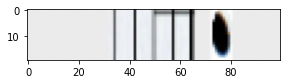

In [126]:
fig = plt.figure(figsize = (10,7))
#fig.add_subplot(2,2,1)
#plt.imshow(testM1_x[5])

fig.add_subplot(2,2,2)
plt.imshow(testM1_x[0])

In [72]:
model.save_weights("NoteClassificationv3.h5")

In [ ]:
import keras
from tensorflow.keras import activations
c = ['G4','A4','B4','C3','D3','E3','F3','G3','A3','B3','C2','D2','E2','F2','G2','A2','B2','C','D','E','F','G']

#GOOD - input: rate, height
input_A = keras.layers.Input(shape = [100,20,3], name = 'noteMask')
#input_B = keras.layers.Input(shape = [100], name = 'staffMask')
#input_B = keras.layers.Input(shape = [1], name = "dis")
#input_C = keras.layers.Input(shape = [1], name = "staffHeihgt")

"""
conv1 = keras.layers.Conv2D(64,1, padding = "same")(input_A)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activations.relu)(conv1)
conv1 = keras.layers.Conv2D(64,1, padding = "same")(conv1)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activations.relu)(conv1)
conv1 = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(conv1)
conv1 = keras.layers.Conv2D(64,1, padding = "same")(conv1)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activations.relu)(conv1)
conv1 = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(conv1)
conv1 = keras.layers.Conv2D(64,1, padding = "same")(conv1)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activations.relu)(conv1)
conv1 = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(conv1)
"""
hidden_A = input_A
for u in range(2):
    initLayer = keras.layers.Conv2D(64,1, padding = "same")(hidden_A)      
    conv1 = keras.layers.BatchNormalization()(initLayer)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    conv1 = keras.layers.Conv2D(64,1, padding = "same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    hidden_A = keras.layers.Add()([conv1, initLayer])
    
originalInput = keras.layers.Conv2D(64,1, padding = "same")(input_A)
originalInput = keras.layers.BatchNormalization()(originalInput)
originalInput = keras.layers.Activation(activations.relu)(originalInput)
hidden_A = keras.layers.Add()([hidden_A,originalInput])

hidden_A = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(hidden_A)

for u in range(2):
    initLayer = keras.layers.Conv2D(64,3, padding = "same")(hidden_A)      
    conv1 = keras.layers.BatchNormalization()(initLayer)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    conv1 = keras.layers.Conv2D(64,3, padding = "same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    hidden_A = keras.layers.Add()([conv1, initLayer])

originalInput = keras.layers.Conv2D(64,3, padding = "same")(input_A)
originalInput = keras.layers.BatchNormalization()(originalInput)
originalInput = keras.layers.Activation(activations.relu)(originalInput)
hidden_A = keras.layers.Add()([hidden_A,originalInput])

hidden_A = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(hidden_A)

for u in range(2):
    initLayer = keras.layers.Conv2D(128,3, padding = "same")(hidden_A)      
    conv1 = keras.layers.BatchNormalization()(initLayer)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    conv1 = keras.layers.Conv2D(128,3, padding = "same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activations.relu)(conv1)
    hidden_A = keras.layers.Add()([conv1, initLayer])
    
originalInput = keras.layers.Conv2D(128,3, padding = "same")(input_A)
originalInput = keras.layers.BatchNormalization()(originalInput)
originalInput = keras.layers.Activation(activations.relu)(originalInput)
hidden_A = keras.layers.Add()([hidden_A,originalInput])

hidden_A = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(hidden_A)

for u in range(2):
    initLayer = keras.layers.Conv2D(256,3, padding = "same")(hidden_A)      
    conv1 = keras.layers.BatchNormalization()(initLayer)
    #conv1 = keras.layers.Activation(activations.relu)(conv1)
    conv1 = keras.layers.Conv2D(256,3, padding = "same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    #conv1 = keras.layers.Activation(activations.relu)(conv1)
    hidden_A = keras.layers.Add()([conv1, initLayer])

originalInput = keras.layers.Conv2D(256,3, padding = "same")(input_A)
originalInput = keras.layers.BatchNormalization()(originalInput)
originalInput = keras.layers.Activation(activations.relu)(originalInput)
hidden_A = keras.layers.Add()([hidden_A,originalInput])    

hidden_A = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(hidden_A)


for u in range(2):
    initLayer = keras.layers.Conv2D(512,3, padding = "same")(hidden_A)      
    conv1 = keras.layers.BatchNormalization()(initLayer)
    #conv1 = keras.layers.Activation(activations.relu)(conv1)
    conv1 = keras.layers.Conv2D(512,3, padding = "same")(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    #conv1 = keras.layers.Activation(activations.relu)(conv1)
    hidden_A = keras.layers.Add()([conv1, initLayer])

originalInput = keras.layers.Conv2D(512,3, padding = "same")(input_A)
originalInput = keras.layers.BatchNormalization()(originalInput)
originalInput = keras.layers.Activation(activations.relu)(originalInput)
hidden_A = keras.layers.Add()([hidden_A,originalInput])  


#hidden_3 = keras.layers.Conv2D(128,3, padding = "same")(conv1)
#conv1 = keras.layers.BatchNormalization()(hidden_3)
conv1 = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(hidden_A)

#conv1 = keras.layers.Flatten()(conv1)

#conv1 = keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(conv1)




hidden_A = keras.layers.Flatten()(conv1)

#hidden_A = keras.layers.Dense(4096, activation = "relu")(hidden_A)
#hidden_B = keras.layers.Dense(4096, activation = 'relu')(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])

hidden_A = keras.layers.Dense(2048, activation = "relu")(hidden_A)
#hidden_B = keras.layers.Dense(2048, activation = 'relu')(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])

hidden_A = keras.layers.Dense(1024, activation = "relu")(hidden_A)
#hidden_B = keras.layers.Dense(1024, activation = 'relu')(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])
#concat = keras.layers.BatchNormalization()(concat)
hidden_A = keras.layers.Dense(512, activation="relu")(hidden_A)
#hidden_B = keras.layers.Dense(512, activation="relu")(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])
#concat = keras.layers.BatchNormalization()(concat)
hidden_A = keras.layers.Dense(256, activation="relu")(hidden_A)
#hidden_B = keras.layers.Dense(256, activation="relu")(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])
#concat = keras.layers.BatchNormalization()(concat)
hidden_A = keras.layers.Dense(128, activation="relu")(hidden_A)
#hidden_B = keras.layers.Dense(128, activation="relu")(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])
#concat = keras.layers.BatchNormalization()(concat)
hidden_A = keras.layers.Dense(64, activation="relu")(hidden_A)
#hidden_B = keras.layers.Dense(64, activation="relu")(input_B)
#hidden_A = keras.layers.Multiply()([hidden_A,hidden_B])
hidden_A = keras.layers.Dense(32, activation="relu")(hidden_A)
    
        
output = keras.layers.Dense(len(c), activation = "softmax")(hidden_A)

#hidden_B1 = keras.layers.Dense(128, activation = "relu")(input_B)
#hidden_B2 = keras.layers.Dense(96, activation = "relu")(hidden_B1)
#final_B = keras.layers.Dense(len(c), activation = "softmax")(flatten)

#concat = keras.layers.concatenate([final_A, final_B])
#output = keras.layers.Dense(len(c),name = "output", activation = "softmax")(concat)

model  = keras.Model(inputs = [input_A], outputs = [output])



"""
model = keras.models.Sequential()
#model.add(keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape = [100,1,3]))
#model.add(keras.layers.MaxPooling2D(1))
model.add(keras.layers.Dense(1, input_shape=[100,1,3]))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.Dense(256, activation = 'relu'))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dense(96, activation = 'relu'))
model.add(keras.layers.Dense(len(c), activation = 'softmax'))
"""

optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, decay=0.01)

model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])